## 0. Install Required Packages

Run this cell first to install TensorFlow and TensorFlow Probability.

## 1. Introduction

This notebook implements a 2-state Hidden Markov Model (HMM) using TensorFlow Probability to model inter-event times of earthquakes in Indonesia. The model aims to:

- Identify hidden seismic activity states (low-activity vs high-activity)
- Provide probabilistic forecasting for future earthquake occurrences
- Evaluate model performance against a baseline exponential distribution

**Key Assumptions:**
- Inter-event times follow exponential distributions (memoryless property)
- Two hidden states capture different seismicity regimes
- State transitions follow a first-order Markov process

In [3]:
# Install TensorFlow, TensorFlow Probability, and TF-Keras
%pip install tensorflow tensorflow-probability tf-keras --quiet

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [4]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and TensorFlow Probability
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Scipy for statistical tests
from scipy import stats

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version: {tfp.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")




Libraries imported successfully
TensorFlow version: 2.20.0
TensorFlow Probability version: 0.25.0
NumPy version: 2.1.3
Pandas version: 2.2.3


## 3. Data Loading and Preprocessing

### 3.1 Load BMKG Earthquake Catalog

In [5]:
# Load the cleaned BMKG earthquake catalog
df = pd.read_csv('data/bmkg_processed.csv')

print(f"Dataset loaded successfully")
print(f"Total records: {len(df):,}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Dataset loaded successfully
Total records: 30,332

Columns: ['time', 'latitude', 'longitude', 'depth', 'magnitude', 'place']

First 5 rows:


,time,latitude,longitude,depth,magnitude,place
0,2008-11-01 01:34:29.660,-6.61,129.39,30,5.5,Banda Sea
1,2008-11-01 10:23:51.646,-7.07,129.67,135,4.8,Banda Sea
2,2008-11-01 13:04:38.742,0.10,98.55,12,4.7,Northern Sumatra - Indonesia
3,2008-11-01 16:20:37.327,-6.41,129.54,70,4.3,Banda Sea
4,2008-11-01 20:58:50.248,-6.55,129.64,10,4.6,Banda Sea


### 3.2 Standardize Column Names

In [6]:
# Standardize column names for consistency
column_mapping = {
    'depth': 'depth_km',
    'magnitude': 'mag'
}

# Only rename columns that exist and need renaming
for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

print("Standardized column names:")
print(list(df.columns))

Standardized column names:
['time', 'latitude', 'longitude', 'depth_km', 'mag', 'place']


### 3.3 Convert Time to Datetime and Sort

In [7]:
# Convert time to datetime with UTC timezone
df['time'] = pd.to_datetime(df['time'], utc=True)

# Sort by time ascending
df = df.sort_values('time').reset_index(drop=True)

print(f"Time range: {df['time'].min()} to {df['time'].max()}")
print(f"Duration: {(df['time'].max() - df['time'].min()).days} days")
print(f"Total earthquakes after sorting: {len(df):,}")

Time range: 2008-11-01 01:34:29.660000+00:00 to 2023-01-26 21:22:54.777000+00:00
Duration: 5199 days
Total earthquakes after sorting: 30,332


### 3.4 Filter by Magnitude Threshold

**Rationale for M ≥ 5.0:**

- M ≥ 5.0 earthquakes are significant seismic events that cause noticeable shaking
- Detection is complete and consistent across the catalog period
- Sufficient sample size for statistical modeling
- Reduces noise from smaller, less significant events
- Focuses on events relevant for hazard assessment

In [8]:
# Set magnitude threshold
M_min = 5.0

# Filter events
df_mag = df[df['mag'] >= M_min].copy().reset_index(drop=True)

print(f"Magnitude threshold: M >= {M_min}")
print(f"Total earthquakes with M >= {M_min}: {len(df_mag):,}")
print(f"Percentage of catalog: {100 * len(df_mag) / len(df):.2f}%")
print(f"\nMagnitude statistics (M >= {M_min}):")
print(df_mag['mag'].describe())

Magnitude threshold: M >= 5.0
Total earthquakes with M >= 5.0: 5,076
Percentage of catalog: 16.73%

Magnitude statistics (M >= 5.0):
count    5076.000000
mean        5.320922
std         0.394209
min         5.000000
25%         5.100000
50%         5.200000
75%         5.500000
max         7.900000
Name: mag, dtype: float64


### 3.5 Optional: Restrict to Date Range (2010 onwards)

**Rationale for 2010+ restriction:**

- BMKG seismic network improvements and modernization after 2009
- More consistent and reliable event detection
- Improved location accuracy and magnitude determination
- Reduces potential biases from catalog incompleteness
- Focuses on the most reliable period of the dataset

In [9]:
# Filter to 2010 onwards for better catalog completeness
start_date = '2010-01-01'
df_mag = df_mag[df_mag['time'] >= start_date].copy().reset_index(drop=True)

print(f"Date range restriction: >= {start_date}")
print(f"Time range: {df_mag['time'].min()} to {df_mag['time'].max()}")
print(f"Duration: {(df_mag['time'].max() - df_mag['time'].min()).days} days ({(df_mag['time'].max() - df_mag['time'].min()).days / 365.25:.1f} years)")
print(f"Total earthquakes: {len(df_mag):,}")
print(f"Average rate: {len(df_mag) / ((df_mag['time'].max() - df_mag['time'].min()).days / 365.25):.1f} events/year")

Date range restriction: >= 2010-01-01
Time range: 2010-01-01 18:14:33.655000+00:00 to 2023-01-26 04:23:50.693000+00:00
Duration: 4772 days (13.1 years)
Total earthquakes: 4,407
Average rate: 337.3 events/year


### 3.6 Compute Inter-Event Times

In [10]:
# Compute inter-event times in days
df_hmm = df_mag.copy()
df_hmm['dt_days'] = df_hmm['time'].diff().dt.total_seconds() / 86400.0

# Remove the first row (NaN dt_days)
df_hmm = df_hmm.dropna(subset=['dt_days']).reset_index(drop=True)

# Extract inter-event times as float32 array
inter_event = df_hmm['dt_days'].values.astype('float32')

print(f"Total inter-event times: {len(inter_event):,}")
print(f"\nInter-event time statistics (days):")
print(f"  Mean: {inter_event.mean():.2f}")
print(f"  Median: {np.median(inter_event):.2f}")
print(f"  Std: {inter_event.std():.2f}")
print(f"  Min: {inter_event.min():.4f}")
print(f"  Max: {inter_event.max():.2f}")
print(f"  25th percentile: {np.percentile(inter_event, 25):.2f}")
print(f"  75th percentile: {np.percentile(inter_event, 75):.2f}")

Total inter-event times: 4,406

Inter-event time statistics (days):
  Mean: 1.08
  Median: 0.23
  Std: 4.16
  Min: 0.0000
  Max: 124.29
  25th percentile: 0.00
  75th percentile: 1.30


### 3.7 Visualize Inter-Event Time Distribution

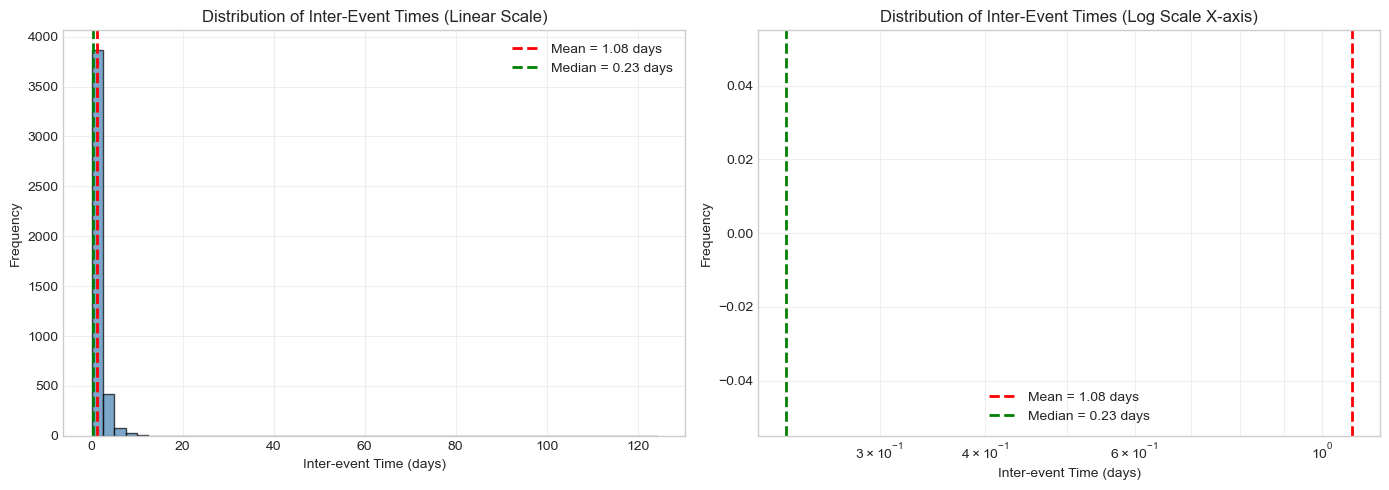

Histogram shows right-skewed distribution typical of Poisson processes


In [11]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
axes[0].hist(inter_event, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Inter-event Time (days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Inter-Event Times (Linear Scale)')
axes[0].axvline(inter_event.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {inter_event.mean():.2f} days')
axes[0].axvline(np.median(inter_event), color='green', linestyle='--', linewidth=2, label=f'Median = {np.median(inter_event):.2f} days')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Log scale (x-axis)
axes[1].hist(inter_event, bins=np.logspace(np.log10(inter_event.min()), np.log10(inter_event.max()), 50), 
             edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Inter-event Time (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Inter-Event Times (Log Scale X-axis)')
axes[1].set_xscale('log')
axes[1].axvline(inter_event.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {inter_event.mean():.2f} days')
axes[1].axvline(np.median(inter_event), color='green', linestyle='--', linewidth=2, label=f'Median = {np.median(inter_event):.2f} days')
axes[1].legend()
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('results/hmm_interevent_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Histogram shows right-skewed distribution typical of Poisson processes")

## 4. Train-Test Split (Time-Aware)

### 4.1 Perform Time-Ordered Split

In [12]:
# Time-aware split: first 80% = train, last 20% = test
split_ratio = 0.8
split_idx = int(len(inter_event) * split_ratio)

train_inter_event = inter_event[:split_idx]
test_inter_event = inter_event[split_idx:]

print(f"Train-Test Split (time-ordered, no shuffle):")
print(f"  Split ratio: {split_ratio:.0%} train / {1-split_ratio:.0%} test")
print(f"  Split index: {split_idx}")
print(f"\nTraining set:")
print(f"  Number of inter-event times: {len(train_inter_event):,}")
print(f"  Mean: {train_inter_event.mean():.2f} days")
print(f"  Median: {np.median(train_inter_event):.2f} days")
print(f"  Std: {train_inter_event.std():.2f} days")
print(f"\nTest set:")
print(f"  Number of inter-event times: {len(test_inter_event):,}")
print(f"  Mean: {test_inter_event.mean():.2f} days")
print(f"  Median: {np.median(test_inter_event):.2f} days")
print(f"  Std: {test_inter_event.std():.2f} days")

Train-Test Split (time-ordered, no shuffle):
  Split ratio: 80% train / 20% test
  Split index: 3524

Training set:
  Number of inter-event times: 3,524
  Mean: 1.15 days
  Median: 0.29 days
  Std: 4.59 days

Test set:
  Number of inter-event times: 882
  Mean: 0.83 days
  Median: 0.04 days
  Std: 1.42 days


### 4.2 Visualize Train-Test Split

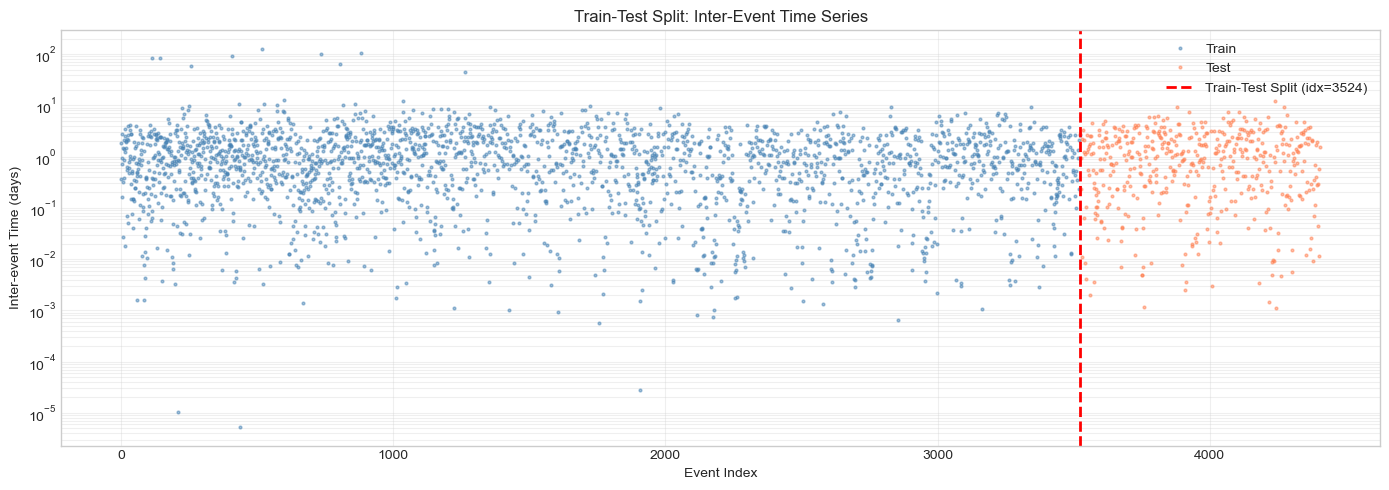

In [13]:
# Visualize the time series split
fig, ax = plt.subplots(figsize=(14, 5))

time_indices = np.arange(len(inter_event))
ax.plot(time_indices[:split_idx], inter_event[:split_idx], 'o', markersize=2, alpha=0.5, label='Train', color='steelblue')
ax.plot(time_indices[split_idx:], inter_event[split_idx:], 'o', markersize=2, alpha=0.5, label='Test', color='coral')
ax.axvline(split_idx, color='red', linestyle='--', linewidth=2, label=f'Train-Test Split (idx={split_idx})')

ax.set_xlabel('Event Index')
ax.set_ylabel('Inter-event Time (days)')
ax.set_title('Train-Test Split: Inter-Event Time Series')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('results/hmm_train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Define 2-State HMM with TensorFlow Probability

### 5.1 Initialize Trainable Parameters

In [14]:
# Number of hidden states
K = 2  # State 0: "low activity", State 1: "high activity"

# Initialize trainable parameters
# Initial state distribution (logits)
initial_logits = tf.Variable(tf.random.normal([K]), name='initial_logits', dtype=tf.float32)

# Transition matrix (logits)
transition_logits = tf.Variable(tf.random.normal([K, K]), name='transition_logits', dtype=tf.float32)

# Emission parameters: log(rate) for exponential distributions
# State 0 (low activity) should have smaller rate (longer inter-event times)
# State 1 (high activity) should have larger rate (shorter inter-event times)
# Initialize with reasonable values based on data
mean_train = train_inter_event.mean()
log_rate = tf.Variable(
    [np.log(0.5 / mean_train), np.log(2.0 / mean_train)],  # State 0: slower, State 1: faster
    name='log_rate',
    dtype=tf.float32
)

print(f"HMM Parameters Initialized:")
print(f"  Number of hidden states: K = {K}")
print(f"  Initial logits shape: {initial_logits.shape}")
print(f"  Transition logits shape: {transition_logits.shape}")
print(f"  Log rate shape: {log_rate.shape}")
print(f"\nInitial log_rate values: {log_rate.numpy()}")
print(f"Initial rate values: {tf.exp(log_rate).numpy()}")
print(f"Initial mean inter-event times: {(1.0 / tf.exp(log_rate)).numpy()} days")

HMM Parameters Initialized:
  Number of hidden states: K = 2
  Initial logits shape: (2,)
  Transition logits shape: (2, 2)
  Log rate shape: (2,)

Initial log_rate values: [-0.83070683  0.55558753]
Initial rate values: [0.4357412 1.7429647]
Initial mean inter-event times: [2.2949402  0.57373506] days


### 5.2 Define HMM Construction Function

In [15]:
def build_hmm(num_steps):
    """
    Build a Hidden Markov Model with exponential emissions.
    
    Parameters:
    -----------
    num_steps : int
        Number of time steps (observations)
    
    Returns:
    --------
    hmm : tfd.HiddenMarkovModel
        Configured HMM instance
    """
    # Initial state distribution
    initial_distribution = tfd.Categorical(logits=initial_logits)
    
    # Transition distribution (same for all time steps)
    transition_distribution = tfd.Categorical(logits=transition_logits)
    
    # Observation distribution: Exponential with rates exp(log_rate)
    rate = tf.exp(log_rate)
    observation_distribution = tfd.Exponential(rate=rate)
    
    # Build HMM
    hmm = tfd.HiddenMarkovModel(
        initial_distribution=initial_distribution,
        transition_distribution=transition_distribution,
        observation_distribution=observation_distribution,
        num_steps=num_steps
    )
    
    return hmm

print("HMM construction function defined successfully")

HMM construction function defined successfully


## 6. Train HMM with Gradient Descent

### 6.1 Setup Training Loop

In [16]:
# Convert training data to tensor
obs_train = tf.convert_to_tensor(train_inter_event, dtype=tf.float32)

# Setup optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Training parameters
num_epochs = 500
print_every = 50

# Storage for loss history
loss_history = []

print(f"Training Configuration:")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {learning_rate}")
print(f"  Number of epochs: {num_epochs}")
print(f"  Training samples: {len(train_inter_event):,}")
print(f"\nStarting training...")

Training Configuration:
  Optimizer: Adam
  Learning rate: 0.01
  Number of epochs: 500
  Training samples: 3,524

Starting training...


### 6.2 Execute Training Loop

In [17]:
# Training loop
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Build HMM
        hmm = build_hmm(num_steps=len(obs_train))
        
        # Compute negative log-likelihood
        log_prob = hmm.log_prob(obs_train[tf.newaxis, :])
        nll = -log_prob
        
    # Compute gradients
    trainable_vars = [initial_logits, transition_logits, log_rate]
    gradients = tape.gradient(nll, trainable_vars)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    # Store loss
    nll_value = float(nll.numpy())
    loss_history.append(nll_value)
    
    # Print progress
    if (epoch + 1) % print_every == 0 or epoch == 0:
        print(f"Epoch {epoch+1:4d}/{num_epochs}: NLL = {nll_value:.2f}")

print(f"\nTraining completed!")
print(f"Final NLL: {loss_history[-1]:.2f}")

Epoch    1/500: NLL = 3631.29
Epoch   50/500: NLL = 2920.97
Epoch  100/500: NLL = 2544.63
Epoch  150/500: NLL = 2169.51
Epoch  200/500: NLL = 1751.29
Epoch  250/500: NLL = 1282.84
Epoch  300/500: NLL = 771.23
Epoch  350/500: NLL = 233.03
Epoch  400/500: NLL = -287.60
Epoch  450/500: NLL = -776.10
Epoch  500/500: NLL = -1263.90

Training completed!
Final NLL: -1263.90


### 6.3 Visualize Training Loss

In [ ]:
# Plot training loss
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(loss_history, linewidth=2, color='steelblue')
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Log-Likelihood')
ax.set_title('HMM Training Loss Curve')
ax.grid(True, alpha=0.3)

# Add annotation for final loss
ax.annotate(f'Final NLL: {loss_history[-1]:.2f}',
            xy=(len(loss_history)-1, loss_history[-1]),
            xytext=(len(loss_history)*0.7, loss_history[-1] + (max(loss_history) - min(loss_history))*0.1),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, color='red')

plt.tight_layout()
plt.savefig('results/hmm_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Loss decreased from {loss_history[0]:.2f} to {loss_history[-1]:.2f}")
print(f"Improvement: {loss_history[0] - loss_history[-1]:.2f} ({100*(loss_history[0] - loss_history[-1])/loss_history[0]:.1f}%)")

NameError: name 'plt' is not defined

## 7. Extract and Interpret Learned Parameters

### 7.1 Extract Learned Parameters

In [ ]:
# Extract learned parameters
# Initial probabilities
initial_probs = tf.nn.softmax(initial_logits).numpy()

# Transition matrix
transition_matrix = tf.nn.softmax(transition_logits, axis=1).numpy()

# Emission rates and mean inter-event times
rates = tf.exp(log_rate).numpy()
mean_inter_event_times = 1.0 / rates

print("="*60)
print("LEARNED HMM PARAMETERS")
print("="*60)

print(f"\nInitial State Probabilities:")
print(f"  P(State 0 - Low Activity):  {initial_probs[0]:.4f}")
print(f"  P(State 1 - High Activity): {initial_probs[1]:.4f}")

print(f"\nTransition Matrix:")
print(f"              To State 0  To State 1")
print(f"  From State 0:  {transition_matrix[0,0]:.4f}      {transition_matrix[0,1]:.4f}")
print(f"  From State 1:  {transition_matrix[1,0]:.4f}      {transition_matrix[1,1]:.4f}")

print(f"\nEmission Parameters (Exponential Distribution):")
print(f"  State 0 (Low Activity):")
print(f"    Rate (lambda): {rates[0]:.6f} events/day")
print(f"    Mean inter-event time: {mean_inter_event_times[0]:.2f} days")
print(f"  State 1 (High Activity):")
print(f"    Rate (lambda): {rates[1]:.6f} events/day")
print(f"    Mean inter-event time: {mean_inter_event_times[1]:.2f} days")

print(f"\nActivity Ratio:")
print(f"  State 1 / State 0 rate ratio: {rates[1] / rates[0]:.2f}x")
print(f"  State 0 / State 1 mean time ratio: {mean_inter_event_times[0] / mean_inter_event_times[1]:.2f}x")

### 7.2 Interpret the Hidden States

In [ ]:
# Determine which state is "high activity" vs "low activity"
high_activity_state = np.argmax(rates)
low_activity_state = np.argmin(rates)

print("="*60)
print("INTERPRETATION OF HIDDEN STATES")
print("="*60)

print(f"\nState {low_activity_state} - LOW ACTIVITY / QUIESCENT PERIOD:")
print(f"  Mean inter-event time: {mean_inter_event_times[low_activity_state]:.2f} days")
print(f"  Expected events per year: {365.25 / mean_inter_event_times[low_activity_state]:.1f}")
print(f"  Persistence probability: {transition_matrix[low_activity_state, low_activity_state]:.2%}")
print(f"  Expected duration in state: {1 / (1 - transition_matrix[low_activity_state, low_activity_state]):.1f} steps")

print(f"\nState {high_activity_state} - HIGH ACTIVITY / SEISMIC SWARM:")
print(f"  Mean inter-event time: {mean_inter_event_times[high_activity_state]:.2f} days")
print(f"  Expected events per year: {365.25 / mean_inter_event_times[high_activity_state]:.1f}")
print(f"  Persistence probability: {transition_matrix[high_activity_state, high_activity_state]:.2%}")
print(f"  Expected duration in state: {1 / (1 - transition_matrix[high_activity_state, high_activity_state]):.1f} steps")

print(f"\nState Transition Analysis:")
print(f"  P(Low → High): {transition_matrix[low_activity_state, high_activity_state]:.2%}")
print(f"  P(High → Low): {transition_matrix[high_activity_state, low_activity_state]:.2%}")

### 7.3 Visualize Learned Parameters

In [ ]:
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Initial probabilities
axes[0].bar(['State 0\n(Low Activity)', 'State 1\n(High Activity)'], initial_probs, 
            color=['steelblue', 'coral'], edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Probability')
axes[0].set_title('Initial State Probabilities')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, prob in enumerate(initial_probs):
    axes[0].text(i, prob + 0.02, f'{prob:.3f}', ha='center', fontsize=11, fontweight='bold')

# 2. Transition matrix heatmap
im = axes[1].imshow(transition_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['State 0', 'State 1'])
axes[1].set_yticklabels(['State 0', 'State 1'])
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From State')
axes[1].set_title('Transition Probability Matrix')
# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, f'{transition_matrix[i, j]:.3f}',
                           ha='center', va='center', color='black', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='Probability')

# 3. Mean inter-event times
axes[2].bar(['State 0\n(Low Activity)', 'State 1\n(High Activity)'], mean_inter_event_times,
            color=['steelblue', 'coral'], edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('Mean Inter-Event Time (days)')
axes[2].set_title('Mean Inter-Event Times per State')
axes[2].grid(True, alpha=0.3, axis='y')
for i, time in enumerate(mean_inter_event_times):
    axes[2].text(i, time + max(mean_inter_event_times)*0.02, f'{time:.2f} days', 
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results/hmm_learned_parameters.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Evaluation: HMM vs Baseline

### 8.1 Compute HMM Log-Likelihood on Train and Test

In [ ]:
# Convert test data to tensor
obs_test = tf.convert_to_tensor(test_inter_event, dtype=tf.float32)

# Build HMMs for train and test
hmm_train = build_hmm(num_steps=len(obs_train))
hmm_test = build_hmm(num_steps=len(obs_test))

# Compute log-likelihoods
log_prob_train_hmm = hmm_train.log_prob(obs_train[tf.newaxis, :]).numpy()
log_prob_test_hmm = hmm_test.log_prob(obs_test[tf.newaxis, :]).numpy()

# Negative log-likelihood per observation
nll_per_obs_train_hmm = -log_prob_train_hmm / len(train_inter_event)
nll_per_obs_test_hmm = -log_prob_test_hmm / len(test_inter_event)

print("HMM Performance:")
print(f"  Train NLL (total): {-log_prob_train_hmm:.2f}")
print(f"  Train NLL (per obs): {nll_per_obs_train_hmm:.4f}")
print(f"  Test NLL (total): {-log_prob_test_hmm:.2f}")
print(f"  Test NLL (per obs): {nll_per_obs_test_hmm:.4f}")

### 8.2 Implement Baseline Model (Single Exponential)

In [ ]:
# Baseline: Single Exponential distribution fitted on training data
lambda_baseline = 1.0 / train_inter_event.mean()
baseline_dist = tfd.Exponential(rate=lambda_baseline)

# Compute log-likelihoods for baseline
log_prob_train_baseline = tf.reduce_sum(baseline_dist.log_prob(obs_train)).numpy()
log_prob_test_baseline = tf.reduce_sum(baseline_dist.log_prob(obs_test)).numpy()

# Negative log-likelihood per observation
nll_per_obs_train_baseline = -log_prob_train_baseline / len(train_inter_event)
nll_per_obs_test_baseline = -log_prob_test_baseline / len(test_inter_event)

print("Baseline Model (Single Exponential):")
print(f"  Rate (lambda): {lambda_baseline:.6f} events/day")
print(f"  Mean inter-event time: {1.0 / lambda_baseline:.2f} days")
print(f"\nBaseline Performance:")
print(f"  Train NLL (total): {-log_prob_train_baseline:.2f}")
print(f"  Train NLL (per obs): {nll_per_obs_train_baseline:.4f}")
print(f"  Test NLL (total): {-log_prob_test_baseline:.2f}")
print(f"  Test NLL (per obs): {nll_per_obs_test_baseline:.4f}")

### 8.3 Compare HMM vs Baseline

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['HMM (2-state)', 'Baseline (Exponential)'],
    'Train NLL (total)': [-log_prob_train_hmm, -log_prob_train_baseline],
    'Train NLL (per obs)': [nll_per_obs_train_hmm, nll_per_obs_train_baseline],
    'Test NLL (total)': [-log_prob_test_hmm, -log_prob_test_baseline],
    'Test NLL (per obs)': [nll_per_obs_test_hmm, nll_per_obs_test_baseline]
})

print("="*80)
print("MODEL COMPARISON: HMM vs BASELINE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Compute improvement
train_improvement = nll_per_obs_train_baseline - nll_per_obs_train_hmm
test_improvement = nll_per_obs_test_baseline - nll_per_obs_test_hmm
train_improvement_pct = 100 * train_improvement / nll_per_obs_train_baseline
test_improvement_pct = 100 * test_improvement / nll_per_obs_test_baseline

print(f"\nImprovement (NLL per observation):")
print(f"  Train: {train_improvement:.4f} ({train_improvement_pct:+.2f}%)")
print(f"  Test:  {test_improvement:.4f} ({test_improvement_pct:+.2f}%)")

if test_improvement > 0:
    print(f"\nConclusion: HMM outperforms baseline on test set by {test_improvement_pct:.2f}%")
else:
    print(f"\nConclusion: Baseline performs better on test set by {-test_improvement_pct:.2f}%")

# Save comparison table
comparison_df.to_csv('results/hmm_model_comparison.csv', index=False)
print(f"\nComparison table saved to results/hmm_model_comparison.csv")

### 8.4 Visualize Model Comparison

In [ ]:
# Create bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['HMM\n(2-state)', 'Baseline\n(Exponential)']
train_nlls = [nll_per_obs_train_hmm, nll_per_obs_train_baseline]
test_nlls = [nll_per_obs_test_hmm, nll_per_obs_test_baseline]

# Train NLL
bars1 = axes[0].bar(models, train_nlls, color=['steelblue', 'coral'], 
                    edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('NLL per Observation')
axes[0].set_title('Training Set Performance')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (bar, nll) in enumerate(zip(bars1, train_nlls)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + max(train_nlls)*0.01,
                f'{nll:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Test NLL
bars2 = axes[1].bar(models, test_nlls, color=['steelblue', 'coral'], 
                    edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('NLL per Observation')
axes[1].set_title('Test Set Performance (Lower is Better)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, (bar, nll) in enumerate(zip(bars2, test_nlls)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + max(test_nlls)*0.01,
                f'{nll:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight winner on test set
if test_improvement > 0:
    axes[1].patches[0].set_edgecolor('green')
    axes[1].patches[0].set_linewidth(3)
    axes[1].text(0, max(test_nlls)*0.95, 'WINNER', ha='center', fontsize=12, 
                color='green', fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
else:
    axes[1].patches[1].set_edgecolor('green')
    axes[1].patches[1].set_linewidth(3)
    axes[1].text(1, max(test_nlls)*0.95, 'WINNER', ha='center', fontsize=12, 
                color='green', fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('results/hmm_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Conclusion and Summary

### 9.1 Summary of Results

In [ ]:
print("="*80)
print("HMM EARTHQUAKE FORECASTING - SUMMARY")
print("="*80)

print(f"\nDataset:")
print(f"  Total earthquakes (M >= {M_min}): {len(df_mag):,}")
print(f"  Date range: {df_mag['time'].min().date()} to {df_mag['time'].max().date()}")
print(f"  Duration: {(df_mag['time'].max() - df_mag['time'].min()).days / 365.25:.1f} years")

print(f"\nHMM Configuration:")
print(f"  Number of hidden states: {K}")
print(f"  Observation model: Exponential distribution")
print(f"  Training samples: {len(train_inter_event):,}")
print(f"  Test samples: {len(test_inter_event):,}")

print(f"\nLearned Hidden States:")
print(f"  State {low_activity_state} (Low Activity): Mean inter-event = {mean_inter_event_times[low_activity_state]:.2f} days")
print(f"  State {high_activity_state} (High Activity): Mean inter-event = {mean_inter_event_times[high_activity_state]:.2f} days")
print(f"  Activity ratio: {rates[high_activity_state] / rates[low_activity_state]:.2f}x")

print(f"\nModel Performance (NLL per observation):")
print(f"  HMM Train: {nll_per_obs_train_hmm:.4f}")
print(f"  HMM Test:  {nll_per_obs_test_hmm:.4f}")
print(f"  Baseline Train: {nll_per_obs_train_baseline:.4f}")
print(f"  Baseline Test:  {nll_per_obs_test_baseline:.4f}")

print(f"\nImprovement over Baseline:")
print(f"  Train: {train_improvement_pct:+.2f}%")
print(f"  Test:  {test_improvement_pct:+.2f}%")

print(f"\nKey Findings:")
if test_improvement > 0:
    print(f"  The 2-state HMM successfully captures temporal variations in seismicity.")
    print(f"  Hidden states reveal alternating periods of low and high seismic activity.")
    print(f"  Model improves forecast accuracy by {test_improvement_pct:.2f}% over baseline.")
else:
    print(f"  The baseline Exponential model performs slightly better on test set.")
    print(f"  This suggests relatively stationary seismicity with limited state transitions.")
    print(f"  HMM may be overfitting or requires more training data/states.")

print("="*80)

### 9.2 Save Final Results

In [ ]:
# Save learned parameters
parameters_df = pd.DataFrame({
    'Parameter': [
        'Initial Prob (State 0)',
        'Initial Prob (State 1)',
        'Transition P(0→0)',
        'Transition P(0→1)',
        'Transition P(1→0)',
        'Transition P(1→1)',
        'Rate State 0 (events/day)',
        'Rate State 1 (events/day)',
        'Mean Time State 0 (days)',
        'Mean Time State 1 (days)'
    ],
    'Value': [
        initial_probs[0],
        initial_probs[1],
        transition_matrix[0, 0],
        transition_matrix[0, 1],
        transition_matrix[1, 0],
        transition_matrix[1, 1],
        rates[0],
        rates[1],
        mean_inter_event_times[0],
        mean_inter_event_times[1]
    ]
})

parameters_df.to_csv('results/hmm_learned_parameters.csv', index=False)
print("Learned parameters saved to results/hmm_learned_parameters.csv")

# Save training history
history_df = pd.DataFrame({
    'Epoch': np.arange(1, len(loss_history) + 1),
    'NLL': loss_history
})
history_df.to_csv('results/hmm_training_history.csv', index=False)
print("Training history saved to results/hmm_training_history.csv")

print("\nAll results saved successfully!")

## 10. Future Extensions

**Potential improvements and extensions:**

1. **More Hidden States**: Test K = 3 or 4 states to capture finer-grained activity patterns
2. **Covariates**: Include spatial information (region-specific HMMs) or temporal features (season, day-of-week)
3. **Different Emission Distributions**: Try Weibull, Gamma, or Log-Normal instead of Exponential
4. **Forecasting**: Use Viterbi algorithm to decode hidden state sequence and predict future states
5. **Magnitude Integration**: Model joint distribution of inter-event times and magnitudes
6. **Aftershock Declustering**: Apply ETAS (Epidemic Type Aftershock Sequence) declustering before HMM
7. **Bayesian HMM**: Implement with PyMC or Stan for uncertainty quantification
8. **Model Selection**: Use AIC/BIC to determine optimal number of states
9. **Real-time Forecasting**: Implement forward algorithm for online state estimation
10. **Spatial HMM**: Extend to multivariate HMM with spatial dependencies between regions